<a href="https://colab.research.google.com/github/Ishmeet7/Ishme_DS_242EX/blob/main/Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing and Importing packages

In [ ]:
import pandas as pd #importing libraries
import numpy as np
import matplotlib.pyplot as plt
from numpy import radians, cos, sin, arcsin, sqrt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.interpolate import griddata

In [ ]:
from google.colab import drive   #mount drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading data

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Data/BMTC.parquet.gzip', engine='pyarrow') # This command loads BMTC data into a dataframe. 
                                                                      # In case of error, install pyarrow using: 
                                                                      # pip install pyarrow
dfInput = pd.read_csv('/content/drive/MyDrive/Data/Input.csv')
dfGroundTruth = pd.read_csv('/content/drive/MyDrive/Data/GroundTruth.csv')

In [ ]:
df.describe()

,BusID,Latitude,Longitude,Speed
count,6.014946e+06,6.014946e+06,6.014946e+06,6.014946e+06
mean,1.504227e+08,1.296631e+01,7.760581e+01,1.110418e+01
std,2.803769e+05,6.350863e-02,7.185203e-02,1.397228e+01
min,1.502121e+08,1.279440e+01,7.741818e+01,0.000000e+00
25%,1.502201e+08,1.292179e+01,7.756099e+01,0.000000e+00
50%,1.502219e+08,1.296695e+01,7.759363e+01,5.000000e+00
75%,1.508109e+08,1.300248e+01,7.765333e+01,2.000000e+01
max,1.508134e+08,1.315513e+01,7.778835e+01,1.200000e+02


In [ ]:
#g=df.groupby('BusID', as_index=False)["Timestamp"].sort_values()

#g["Timestamp"], format="%Y-%m-%d %H:%M:%S").sort_values()

# Exploratory Data Analysis

In [ ]:
g1=df.groupby('BusID') #grouping data using BusID
unique=df.BusID.unique()

In [ ]:
def density_plot(df):
    df= df.round({'Latitude': 3,'Longitude': 3})
    data = df.groupby(['Latitude','Longitude'], as_index=False).size()
    data = data[data['size']<7000]  # change this value to remove lesser outliers
    grid_x, grid_y = np.mgrid[12.78:13.16:200j, 77.40:77.80:200j]
    grid_z = griddata(data[['Latitude','Longitude']], data['size'], (grid_x, grid_y), method='nearest')
    plt.figure(figsize=(10,7))
    plt.contourf(grid_x, grid_y, grid_z, 20, cmap='plasma')
    plt.colorbar();
    plt.grid(b = True, alpha= 0.5)


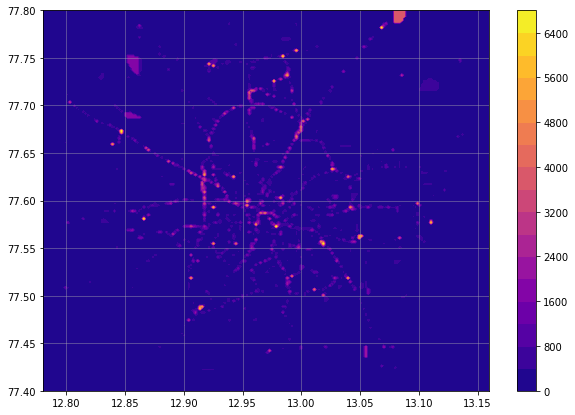

In [ ]:
density_plot(df)

# Preprocessing

In [ ]:
def pre_processing(df):
  d1 = df.drop_duplicates(subset=['Latitude','Longitude','Speed'],keep=("first"),inplace=False) #If the consecutive rows have same latitude,longitude and speed values keeping only first and last row
  d2 = df.drop_duplicates(subset=['Latitude','Longitude','Speed'],keep=("last"),inplace=False)
  d3 = pd.concat([d1,d2]).drop_duplicates()
  return d3

In [ ]:
pre_processing(df)

,BusID,Latitude,Longitude,Speed,Timestamp
0,150212121,13.074558,77.445549,0.0,2019-08-01 07:00:02
152,150212121,13.074558,77.445549,9.0,2019-08-01 07:25:16
153,150212121,13.074113,77.445282,21.0,2019-08-01 07:25:26
154,150212121,13.074060,77.445267,0.0,2019-08-01 07:25:36
173,150212121,13.074060,77.445267,13.0,2019-08-01 07:28:45
...,...,...,...,...,...
6014786,150813395,13.099629,77.596695,0.0,2019-08-01 18:33:36
6014803,150813395,13.099418,77.596924,0.0,2019-08-01 18:36:26
6014823,150813395,13.099084,77.597076,0.0,2019-08-01 18:39:44
6014852,150813395,13.095264,77.594536,0.0,2019-08-01 18:44:33


## Creating a Subset of Data Based on similar route

In [ ]:
g = df.groupby('BusID')

bus1 = g.get_group(150218010)
bus2 = g.get_group(150813389)

bus1.reset_index(inplace = True, drop = True)
bus2.reset_index(inplace = True, drop = True)

buses = pd.concat([bus1,bus2],axis=0)

lat = np.array(buses['Latitude']).reshape(-1, 1)
poly_feature = PolynomialFeatures(4)#degree is 4
x_poly = poly_feature.fit_transform(lat)#fit data and then transform
reg = LinearRegression()
reg.fit(x_poly, buses['Longitude'])#fit linear model
y_predict = reg.predict(x_poly)#prediction using model
rmse = (mse(buses['Longitude'], y_predict)) ** 0.5  #rmse calculation

count = 0
cluster = pd.DataFrame()
for i in g.size().index:
    bus = g.get_group(i)
    bus.reset_index(inplace = True, drop = True)
    lat = np.array(bus['Latitude']).reshape(-1, 1)
    x_poly = poly_feature.fit_transform(lat)
    y_predict = reg.predict(x_poly)#prediction using model
    rmse = (mse(bus['Longitude'], y_predict)) ** 0.5  #rmse calculation
    if rmse <= 0.03:
        count+=1
        cluster = pd.concat([cluster,bus], axis=0)
        
print(count)




105


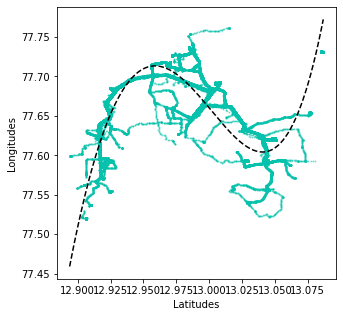

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(cluster['Latitude'], cluster['Longitude'], color='xkcd:turquoise', alpha=0.4, s=1)
xp = np.linspace(cluster['Latitude'].min(), cluster['Latitude'].max(), 1000).reshape(-1, 1)#2923 is len of train data
x_poly = poly_feature.fit_transform(xp)
y_predict = reg.predict(x_poly)
plt.plot(xp,y_predict,'k--')
plt.xlabel('Latitudes')
plt.ylabel('Longitudes')
cluster=cluster.drop(cluster.groupby("BusID").head(1).index, axis=0)

In [ ]:
dfInput.columns

Index(['Unnamed: 0', 'Source_Lat', 'Source_Long', 'Dest_Lat', 'Dest_Long'], dtype='object')

# Feature Extraction

In [ ]:
#calculating Haversine distance between two points on earth
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """

    #Convert decimal degrees to Radians:
    lon1 = np.radians(lon1.values)
    lat1 = np.radians(lat1.values)
    lon2 = np.radians(lon2.values)
    lat2 = np.radians(lat2.values)

    #Implementing Haversine Formula: 
    dlon = np.subtract(lon2, lon1)
    dlat = np.subtract(lat2, lat1)

    a = np.add(np.power(np.sin(np.divide(dlat, 2)), 2), np.multiply(np.cos(lat1),np.multiply(np.cos(lat2), np.power(np.sin(np.divide(dlon, 2)), 2))))  
                          
    c = np.multiply(2, np.arcsin(np.sqrt(a)))
    r = 6371
    
    return c*r

In [ ]:
d3 = cluster
d4=d3.loc[:,["Latitude",'Longitude']]
d7=d3.shift(1)             #creating a lag of p=1
d5=d4.shift(periods=1, freq=None, axis=0)

d5.rename(columns = {'Latitude':'Source_Lat', 'Longitude':'Source_Long'}, inplace = True) #concatenating shifted dataframe to original dataframe and renaming columns
d4.rename(columns = {'Latitude':'Dest_Lat', 'Longitude':'Dest_Long'}, inplace = True)
d6=pd.concat([d5,d4], axis=1)

distance=haversine(d4['Dest_Long'],d4['Dest_Lat'],d5['Source_Long'],d5['Source_Lat'])

time=d3['Timestamp']-d7['Timestamp'] #calculating time required to travel distance between two consecutive rows of latitude and logitude

time=time.apply(lambda x: x.seconds/60)

d6['Distance']=distance   #adding new columns to dataframe
d6['Duration']=time


In [ ]:
d6.columns

Index(['Source_Lat', 'Source_Long', 'Dest_Lat', 'Dest_Long', 'Distance',
       'Duration'],
      dtype='object')

In [ ]:
d6.describe()

,Source_Lat,Source_Long,Dest_Lat,Dest_Long,Distance,Duration
count,329925.000000,329925.000000,329926.000000,329926.000000,329925.000000,329925.000000
mean,12.975449,77.656285,12.975448,77.656285,0.040481,0.456103
std,0.047119,0.041181,0.047119,0.041182,0.245422,13.394551
min,12.893810,77.518929,12.893810,77.518929,0.000000,0.000000
25%,12.924348,77.624619,12.924348,77.624619,0.000000,0.166667
50%,12.977932,77.662460,12.977932,77.662460,0.004403,0.166667
75%,13.012313,77.689400,13.012313,77.689400,0.055452,0.166667
max,13.086927,77.761818,13.086927,77.761818,23.399302,1203.916667


In [ ]:
d6.head() #created dataframe

,Source_Lat,Source_Long,Dest_Lat,Dest_Long,Distance,Duration
1,NaN,NaN,13.043061,77.610191,NaN,NaN
2,13.043061,77.610191,13.042920,77.611275,0.118468,0.166667
3,13.042920,77.611275,13.042670,77.612312,0.115723,0.166667
4,13.042670,77.612312,13.042445,77.613235,0.103068,0.166667
5,13.042445,77.613235,13.042300,77.613518,0.034638,0.166667


In [ ]:
d6.replace([np.inf, -np.inf], np.nan, inplace=True)    #replacing very large values with Nan
d6.drop(d6.tail(1).index, #dropping the first and last rows from dataframe
        inplace = True)
d6.drop(d6.head(1).index,
        inplace = True)

pd.set_option('mode.use_inf_as_na', True)
d6.dropna(how='any', inplace=True)       #dropping rows with Nan values from new dataframe
# check = d6[d6.isna().any(axis=1)]

In [ ]:
# # d6.reset_index(inplace=True)
# plt.figure(figsize=(10,10))
# for i in range(10000):
#     plt.plot([d6['Source_Lat'][i],d6['Dest_Lat'][i]],[d6['Source_Long'][i],d6['Dest_Long'][i]])

In [ ]:
X_train=d6.drop(['Duration'],axis=1) #creating training dataset 
#dropping Duration attribute

In [ ]:
X_train

,Source_Lat,Source_Long,Dest_Lat,Dest_Long,Distance
2,13.043061,77.610191,13.042920,77.611275,0.118468
3,13.042920,77.611275,13.042670,77.612312,0.115723
4,13.042670,77.612312,13.042445,77.613235,0.103068
5,13.042445,77.613235,13.042300,77.613518,0.034638
6,13.042300,77.613518,13.042288,77.613564,0.005159
...,...,...,...,...,...
3441,12.916583,77.572472,12.916560,77.572182,0.031534
3442,12.916560,77.572182,12.916540,77.572044,0.015121
3443,12.916540,77.572044,12.916533,77.571754,0.031440
3444,12.916533,77.571754,12.916572,77.571442,0.034092


In [ ]:
y_train=d6['Duration']  #creating target variable

In [ ]:
y_train

2       0.166667
3       0.166667
4       0.166667
5       0.166667
6       0.183333
          ...   
3441    0.166667
3442    0.166667
3443    0.166667
3444    0.166667
3445    0.166667
Name: Duration, Length: 329766, dtype: float64

In [ ]:
d6.to_parquet('data.parquet.gzip',engine='pyarrow',compression='gzip')

In [ ]:
out = pd.cut(d6['Distance'], bins=[-0.1, 0, 0.05, 0.1, 0.2, 0.4, 1, 2, 5, 10, 20, 40, 50], include_lowest=True)
out1 = pd.cut(d6['Duration'], bins=[-0.1, 0, 0.1, 0.5, 1, 4, 10, 20, 50, 90, 180, 300, 500, 800, 1200, 1500], include_lowest=True)
out1.value_counts()

(0.1, 0.5]          325527
(0.5, 1.0]            1551
(0.0, 0.1]            1472
(10.0, 20.0]           662
(1.0, 4.0]             360
(20.0, 50.0]           124
(4.0, 10.0]             28
(-0.101, 0.0]           23
(50.0, 90.0]            14
(180.0, 300.0]           3
(90.0, 180.0]            1
(300.0, 500.0]           1
(500.0, 800.0]           0
(800.0, 1200.0]          0
(1200.0, 1500.0]         0
Name: Duration, dtype: int64

In [ ]:
# use this method to create the test data along with the labels
def create_test(input,truth):      # pass the X labels and y labels as parameters
    test_df = input 
    distance1=haversine(test_df['Dest_Long'],test_df['Dest_Lat'],test_df['Source_Long'],test_df['Source_Lat'])
    test_df['Distance']=distance1         #creating distance attribute
    test_df.replace([np.inf, -np.inf], np.nan, inplace=True)      #replacing very large values with Nan
    if "Unnamed: 0" in truth.columns:
        truth.drop("Unnamed: 0",axis=1,inplace=True)
    if "Unnamed: 0" in test_df.columns:
        test_df.drop("Unnamed: 0",axis=1,inplace=True)
    test = pd.concat([test_df,truth],axis=1)
    return test


# Linear Regression Model

In [ ]:
reg_model=LinearRegression(n_jobs=4) 
#reg_model.fit((X_train["Distance"].to_numpy().reshape(-1,1)), y_train)
reg_model.fit(X_train, y_train)

LinearRegression(n_jobs=4)

In [ ]:
test = create_test(dfInput,dfGroundTruth)
test.columns

Index(['Source_Lat', 'Source_Long', 'Dest_Lat', 'Dest_Long', 'Distance', 'TT'], dtype='object')

In [ ]:
y_test=test['TT']

In [ ]:
test.corr(method ='pearson')

,Source_Lat,Source_Long,Dest_Lat,Dest_Long,Distance,TT
Source_Lat,1.000000,-0.051697,0.747833,-0.063366,-0.028416,-0.046561
Source_Long,-0.051697,1.000000,-0.070110,0.801964,-0.017583,-0.014871
Dest_Lat,0.747833,-0.070110,1.000000,-0.095723,-0.006238,-0.052645
Dest_Long,-0.063366,0.801964,-0.095723,1.000000,0.043842,0.038302
Distance,-0.028416,-0.017583,-0.006238,0.043842,1.000000,0.841405
TT,-0.046561,-0.014871,-0.052645,0.038302,0.841405,1.000000


In [ ]:
test.describe()

,Source_Lat,Source_Long,Dest_Lat,Dest_Long,Distance,TT
count,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000
mean,12.964076,77.606528,12.964482,77.611345,6.269450,32.526445
std,0.074979,0.076524,0.072193,0.076525,4.692632,23.069809
min,12.794401,77.418312,12.794438,77.418381,0.501935,0.666667
25%,12.916577,77.560646,12.917477,77.564011,1.883177,9.950000
50%,12.963935,77.595894,12.964300,77.600563,5.643676,28.050000
75%,13.009059,77.659546,13.003739,77.662979,9.601487,59.783333
max,13.155079,77.788261,13.155124,77.788300,29.875871,60.000000


In [ ]:
test.drop("TT",axis=1,inplace=True)

In [ ]:
print("rmse",reg_model.score(test, y_test))

rmse 0.48999438081730506


In [ ]:
# test=test.reshape(-1, 1)
pred = reg_model.predict(test)
print("mae = ",mean_absolute_error(y_test,pred))

mae =  12.263528887669082


Text(0, 0.5, 'Predicted Travel Time')

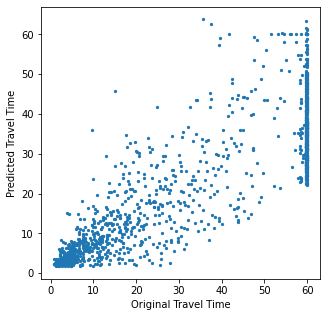

In [ ]:
pred = pd.DataFrame(pred)
check = pd.concat([y_test,pred],axis=1)
check = check.sort_values(by='TT')
check.loc[check[0] > 64, 0] = 60
plt.figure(figsize=(5,5))
plt.scatter(check['TT'],check[0], s=5)
plt.xlabel('Original Travel Time')
plt.ylabel('Predicted Travel Time')


MAE for 2 is 12.10199300498324
MAE for 3 is 89.95113682711877
MAE for 4 is 360.811958303185
MAE for 5 is 141.80286143211083
MAE for 6 is 2830.2723886466547
MAE for 7 is 34015.05797429723
MAE for 8 is 257559.46425692362


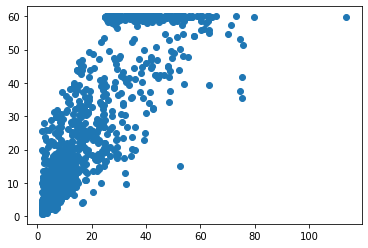

In [ ]:

for p in range(2,9):
    poly_features = PolynomialFeatures(p)#degree is p
    x_poly = poly_features.fit_transform((X_train["Distance"].to_numpy()).reshape(-1, 1))
    #x_poly = poly_features.fit_transform(X_train)
    reg = LinearRegression()
    reg.fit(x_poly, y_train)
    x_test_poly = poly_features.fit_transform((test["Distance"].to_numpy()).reshape(-1, 1))
    #x_test_poly = poly_features.fit_transform(test)

    y_predict = reg.predict(x_test_poly)
    mae = (mean_absolute_error(y_test, y_predict)) 
    if p==2:
      # y_predict = pd.DataFrame(y_predict)
      # check = pd.concat([y_test,y_predict],axis=1)
      # check = check.sort_values(by='TT')
      # check
      # plt.figure(figsize=(10,10))
      # plt.plot(check['TT'],check[0])
      plt.scatter(y_predict,y_test)

    
    print("MAE for", p, 'is', mae)
    

# Random Forest Model

In [ ]:
#Xtrain,Xtest,ytrain,ytest = train_test_split(X_train,y_train, train_size = 0.6, random_state=42,shuffle=False) 

In [ ]:
# forest_model = RandomForestRegressor(random_state=1,oob_score=True,)
# forest_model.fit(X_train, y_train)
# #print("yes")

In [ ]:
forest_model = RandomForestRegressor(random_state=1,oob_score=True,)
forest_model.fit(X_train.head(18000), y_train.head(18000))

RandomForestRegressor(oob_score=True, random_state=1)

In [ ]:
pred = forest_model.predict(test)
print("Mean absolute error obtained is:",mean_absolute_error(y_test, pred))

Mean absolute error obtained is: 11.297089873247877


In [ ]:
pred

array([ 1.14966667,  0.88033333, 16.06766667, ..., 48.84516667,
       32.4505    , 57.423     ])

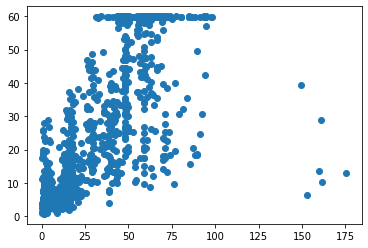

In [ ]:
plt.scatter(pred,y_test)

In [ ]:
#dfInput['ETT']=pred

In [ ]:
#dfInput

In [ ]:
dfGroundTruth

,TT
0,2.833333
1,1.500000
2,21.250000
3,2.000000
4,35.733333
...,...
1200,27.233333
1201,26.750000
1202,53.600000
1203,59.616667


# For Evaluation
function for evauation
  2. Function arguments:
    
    a. df: It is a pandas dataframe that contains the data from BMTC.parquet.gzip
   
    b. dfInput: It is a pandas dataframe that contains the input from Input.csv

3. Returns:

    a. dfOutput: It is a pandas dataframe that contains the output


In [ ]:
def EstimatedTravelTime(df, dfInput): # The output of this function will be evaluated
    # Function body - Begins
    # Make changes here.  
                              
    dfOutput = pd.DataFrame()


    # Function body - Ends
    return dfOutput

In [ ]:
dfOutput = EstimatedTravelTime(df, dfInput)

In [ ]:
bus_df= pd.read_parquet('/content/drive/MyDrive/Data/BMTC.parquet.gzip', engine='pyarrow')
# bus_df=bus_df.drop(["BusID","Speed"],axis=1)
# source=bus_df.sample(n=400,replace=True,random_state=1)

# source.rename(columns = {'Latitude':'Source_Lat',"Longitude":"Source_Long","Timestamp":"t1"}, inplace = True)
# source.reset_index(inplace = True)
# destination=bus_df.sample(n=400,random_state=2)
# destination.reset_index(inplace = True)
# destination.rename(columns = {'Latitude':'Dest_Lat',"Longitude":"Dest_Long","Timestamp":"t2"}, inplace = True)
# merge_df=pd.concat([source,destination],axis=1)
#merge_df=pd.merge(source,destination,axis=1,)

In [ ]:
#bus_df=bus_df.groupby('BusID')

In [ ]:
# merge_df.columns
# merge_df["Distance"]=haversine(merge_df['Dest_Long'],merge_df['Dest_Lat'],merge_df['Source_Long'],merge_df['Source_Lat'])
# time=merge_df
# merge_df["Duration"]=

In [ ]:
bus_df.drop("Speed",axis=1,inplace=True)

In [ ]:

bus_df=bus_df.groupby('BusID').apply(lambda x: x.sample(2)).reset_index(drop=True)

bus_df.rename(columns = {'Latitude':'Source_Lat', 'Longitude':'Source_Long',"Timestamp":"t1"}, inplace = True) 

shifted_df=bus_df.shift(1)
shifted_df.rename(columns = {'Source_Lat':'Dest_Lat', 'Source_Long':'Dest_Long',"t1":"t2"}, inplace = True)
final_df=pd.concat([bus_df,shifted_df], axis=1)


In [ ]:
final_df=final_df.iloc[1::2].reset_index()

In [ ]:

time=abs(final_df["t2"]-final_df["t1"])

final_df["Distance"]=haversine(final_df['Dest_Long'],final_df['Dest_Lat'],final_df['Source_Long'],final_df['Source_Lat'])
final_df["Duration"]=time.apply(lambda x: x.seconds/60)

In [ ]:
test_df=final_df.drop(columns=["index","BusID","t1","BusID","t2"])

In [ ]:
final_df

,index,BusID,Source_Lat,Source_Long,t1,BusID,Dest_Lat,Dest_Long,t2,Distance,Duration
0,1,150212121,13.003543,77.571342,2019-08-01 13:55:13,150212121.0,12.977712,77.573898,2019-08-01 16:02:27,2.885596,127.233333
1,3,150218000,12.996608,77.669151,2019-08-01 11:59:00,150218000.0,13.006678,77.688255,2019-08-01 18:55:27,2.353277,416.450000
2,5,150218006,12.999258,77.584007,2019-08-01 09:14:37,150218006.0,12.972501,77.538223,2019-08-01 18:50:18,5.784558,575.683333
3,7,150218010,12.921819,77.660797,2019-08-01 17:26:06,150218010.0,12.916267,77.635857,2019-08-01 17:19:27,2.772608,6.650000
4,9,150218014,13.002195,77.683495,2019-08-01 14:32:48,150218014.0,12.967098,77.702232,2019-08-01 17:03:22,4.399092,150.566667
...,...,...,...,...,...,...,...,...,...,...,...
1937,3875,150813386,13.081468,77.559685,2019-08-01 08:08:39,150813386.0,12.977438,77.572205,2019-08-01 09:23:41,11.646852,75.033333
1938,3877,150813387,12.933600,77.689072,2019-08-01 15:53:48,150813387.0,12.922886,77.670105,2019-08-01 16:55:56,2.375852,62.133333
1939,3879,150813389,13.006970,77.662727,2019-08-01 10:44:53,150813389.0,12.916601,77.604019,2019-08-01 18:34:26,11.893066,469.550000
1940,3881,150813393,12.938225,77.492752,2019-08-01 16:47:57,150813393.0,13.084155,77.549728,2019-08-01 08:04:57,17.361114,523.000000


In [ ]:
test_df

,Source_Lat,Source_Long,Dest_Lat,Dest_Long,Distance,Duration
0,13.003543,77.571342,12.977712,77.573898,2.885596,127.233333
1,12.996608,77.669151,13.006678,77.688255,2.353277,416.450000
2,12.999258,77.584007,12.972501,77.538223,5.784558,575.683333
3,12.921819,77.660797,12.916267,77.635857,2.772608,6.650000
4,13.002195,77.683495,12.967098,77.702232,4.399092,150.566667
...,...,...,...,...,...,...
1937,13.081468,77.559685,12.977438,77.572205,11.646852,75.033333
1938,12.933600,77.689072,12.922886,77.670105,2.375852,62.133333
1939,13.006970,77.662727,12.916601,77.604019,11.893066,469.550000
1940,12.938225,77.492752,13.084155,77.549728,17.361114,523.000000


In [ ]:
test_df["speed"]=test_df["Distance"]/test_df["Duration"] #speed in km/min

<ipython-input-82-c74f06d3e833>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["speed"]=test_df["Distance"]/test_df["Duration"] #speed in km/min


In [ ]:
test_df

,Source_Lat,Source_Long,Dest_Lat,Dest_Long,Distance,Duration,speed
0,13.003543,77.571342,12.977712,77.573898,2.885596,127.233333,0.022680
1,12.996608,77.669151,13.006678,77.688255,2.353277,416.450000,0.005651
2,12.999258,77.584007,12.972501,77.538223,5.784558,575.683333,0.010048
3,12.921819,77.660797,12.916267,77.635857,2.772608,6.650000,0.416933
4,13.002195,77.683495,12.967098,77.702232,4.399092,150.566667,0.029217
...,...,...,...,...,...,...,...
1937,13.081468,77.559685,12.977438,77.572205,11.646852,75.033333,0.155222
1938,12.933600,77.689072,12.922886,77.670105,2.375852,62.133333,0.038238
1939,13.006970,77.662727,12.916601,77.604019,11.893066,469.550000,0.025329
1940,12.938225,77.492752,13.084155,77.549728,17.361114,523.000000,0.033195


In [ ]:
#test_df=test_df.sort_values(by=["speed"],axis=0,ascending=False,na_position="last",ignore_index=True)

In [ ]:
test_df=test_df[test_df["speed"]>0.02] #0.02km/min =1.2km/hr

In [ ]:
test_df.reset_index()

,index,Source_Lat,Source_Long,Dest_Lat,Dest_Long,Distance,Duration,speed
0,0,13.003543,77.571342,12.977712,77.573898,2.885596,127.233333,0.022680
1,3,12.921819,77.660797,12.916267,77.635857,2.772608,6.650000,0.416933
2,4,13.002195,77.683495,12.967098,77.702232,4.399092,150.566667,0.029217
3,5,12.924267,77.648163,13.002404,77.683609,9.499577,136.966667,0.069357
4,6,13.003893,77.549217,12.919664,77.476944,12.208735,60.750000,0.200967
...,...,...,...,...,...,...,...,...
1083,1937,13.081468,77.559685,12.977438,77.572205,11.646852,75.033333,0.155222
1084,1938,12.933600,77.689072,12.922886,77.670105,2.375852,62.133333,0.038238
1085,1939,13.006970,77.662727,12.916601,77.604019,11.893066,469.550000,0.025329
1086,1940,12.938225,77.492752,13.084155,77.549728,17.361114,523.000000,0.033195


In [ ]:
bus_df= pd.read_parquet('/content/drive/MyDrive/Data/BMTC.parquet.gzip', engine='pyarrow')

In [ ]:
g=bus_df.groupby('BusID')

In [ ]:
import random 
# random.sample(range(1, 50), 7)

In [ ]:
random_df=g.nth([100,600])

# AutoML

In [ ]:
#!apt install -y build-essential swig curl

In [ ]:
# !pip install auto-sklearn

In [ ]:
# Install packages
# !curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install
# !pip install auto-sklearn

In [ ]:
# from autosklearn.regression import AutoSklearnRegressor
# # Create the AutoSklearnRegessor
# sklearn = AutoSklearnRegressor(time_left_for_this_task=360,per_run_time_limit=30,memory_limit=5000,n_jobs=-1)
# # Fit the training data
# sklearn.fit(Xtrain, ytrain)
# # Sprint Statistics
# print(sklearn.sprint_statistics())
# # Predict the validation data
# pred_sklearn = sklearn.predict(X_test)
# # Compute the RMSE
# rmse_sklearn=MSE(y_test, pred_sklearn)**0.5
# print('RMSE: ' + str(rmse_sklearn))

In [ ]:
# sklearn.get_models_with_weights()

In [ ]:
# sklearn.leaderboard()

In [ ]:
# from autosklearn.regression import AutoSklearnRegressor
# # Create the AutoSklearnRegessor
# sklearn = AutoSklearnRegressor(time_left_for_this_task=360,per_run_time_limit=45,memory_limit=5500,n_jobs=-1)
# # Fit the training data
# sklearn.fit(Xtrain, ytrain)
# # Sprint Statistics
# print(sklearn.sprint_statistics())
# # Predict the validation data
# pred_sklearn = sklearn.predict(X_test)
# # Compute the RMSE
# rmse_sklearn=MSE(y_test, pred_sklearn)**0.5
# print('RMSE: ' + str(rmse_sklearn))

In [ ]:
# sklearn.leaderboard()

In [ ]:
# from autosklearn.regression import AutoSklearnRegressor
# # Create the AutoSklearnRegessor
# sklearn = AutoSklearnRegressor(time_left_for_this_task=36000,per_run_time_limit=3600,memory_limit=5000,n_jobs=-1)
# # Fit the training data
# sklearn.fit(Xtrain, ytrain)
# # Sprint Statistics
# print(sklearn.sprint_statistics())
# # Predict the validation data
# pred_sklearn = sklearn.predict(X_test)
# # Compute the RMSE
# rmse_sklearn=MSE(y_test, pred_sklearn)**0.5
# print('RMSE: ' + str(rmse_sklearn))

In [ ]:
# import matplotlib.pyplot as plt 
# # Scatter plot true and predicted values
# plt.scatter(pred_sklearn, y_val, alpha=0.2)
# plt.xlabel('predicted')
# plt.ylabel('true value')